### Summary ###
This notebook pre-trains a small language model (SLM) <b>gemma3-1b-it</b> for sentiment analysis. The basic idea is to frame the "pre-training" as a supervised fine-tuning (SFT) problem, where examples of prompt-completion pairs are used to fine-tune the SLM using PEFT technique. The user provides an instruction along with the text on which the model is to perform sentiment analysis, and the model returns its response. We compare the model’s performance on this task before and after fine-tuning to observe the gains.

<b>Note:</b> We deliberately formulate this as a generative problem, as we will be subsequently fine-tuning the SLM for multiple NLP tasks. If the model were to be used only for a single classification task, a better approach would have been to attach a classification head to the SLM and then fine-tune it. We use <a href="https://unsloth.ai/">Unsloth</a>, as it abstracts away a lot of complexities and enables fine-tuning on limited hardware (e.g. runs on google colab, or even on RTX 3060 with just 12GB of VRAM).

To run this notebook locally, it is recommended to create a separate conda enviornment for unsloth using the following commands from your terminal
<code>
conda create -n unsloth_env python=3.10 -y
conda activate unsloth_env
pip install python-dotenv unsloth scikit-learn matplotlib pandas datasets trl
</code>

Optional Step: upgrade unsloth to latest version without updating the dependencies
<code>
pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
</code>

In [1]:
## setup
#%%capture
# Do this only in Colab notebooks!
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install python-dotenv

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from datasets import Dataset
from unsloth import FastModel,FastLanguageModel
from unsloth.chat_templates import get_chat_template, standardize_data_formats
from trl import SFTTrainer, SFTConfig
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
warnings.filterwarnings("ignore")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### 1. load dataset and analyze


In [3]:
## dataset source: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
full_data = pd.read_csv("all-data.csv",names=["sentiment", "text"],encoding="utf-8", encoding_errors="replace")
## view datasample
full_data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
## check class distribution
full_data.sentiment.value_counts()

,count
sentiment,
neutral,2879
positive,1363
negative,604


### 2. Balance the dataset and create splits

In [5]:

min_count = full_data.sentiment.value_counts().min()
# round min_count to a multiple of 100
min_count = min_count - min_count%100
print("Balancing to min class count:", min_count)
df_splits = []
for sentiment in full_data.sentiment.unique():
    df_splits.append(full_data[full_data.sentiment == sentiment].sample(n = min_count, random_state=42))
balanced_df = pd.concat(df_splits,axis=0)

# === Shuffle and split === #
train_df, test_df = train_test_split(balanced_df, test_size=300, stratify=balanced_df['sentiment'], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=150, stratify=train_df['sentiment'], random_state=42)

print(f'Creating splits:train={len(train_df)},vaidation={len(val_df)},test={len(test_df)}')
# You can print value counts to confirm balance
print("Train:", train_df['sentiment'].value_counts().to_dict())
print("Val:", val_df['sentiment'].value_counts().to_dict())
print("Test:", test_df['sentiment'].value_counts().to_dict())

## save the splits to run experiments from other notebooks/scripts
train_df.to_csv("sentiment_train_split.csv",index=False)
val_df.to_csv("sentiment_validation_split.csv",index=False)
test_df.to_csv("sentiment_test_split.csv",index=False)

Balancing to min class count: 600
Creating splits:train=1350,vaidation=150,test=300
Train: {'neutral': 450, 'positive': 450, 'negative': 450}
Val: {'positive': 50, 'negative': 50, 'neutral': 50}
Test: {'negative': 100, 'neutral': 100, 'positive': 100}


### 3. Convert to Unsloth chat format

In [6]:

def format_as_conversations(df, test=False):

    prompt_template_new = (
        "Analyze the sentiment of the following news article text. "
        "Return one of: positive, neutral, negative.\n\n"
        "####Text: {text} ="
    )
    conversations = []
    for i in range(len(df)):
        user_msg = prompt_template_new.format(text=df.iloc[i]['text'])
        convo = [{"role": "user", "content": user_msg}]
        if not test:
            convo.append({"role": "model", "content": df.iloc[i]['sentiment']})
        conversations.append(convo)
    return {"conversations": conversations}

train_ds = Dataset.from_dict(format_as_conversations(train_df))
val_ds   = Dataset.from_dict(format_as_conversations(val_df))
test_ds  = Dataset.from_dict(format_as_conversations(test_df, test=True))  # no labels here

In [7]:
## load huggingface token from .env file
load_dotenv()
hf_token=os.getenv("HF_TOKEN")
## add your huggingface token as some models may be gated

##### optional: force download of a model snapshot to the local cache
<code>
from huggingface_hub import snapshot_download
snapshot_download(repo_id="unsloth/gemma-3-1b-it",token=hf_token)
    
</code>


### 4. Load model and tokenizer

In [16]:
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-1b-it",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    token=hf_token,
)

==((====))==  Unsloth 2025.6.3: Fast Gemma3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


### 5. Standardize & Apply chat templates for gemma3

In [9]:
tokenizer = get_chat_template(tokenizer, chat_template="gemma-3")


train_ds = standardize_data_formats(train_ds, aliases_for_assistant=["model"])
val_ds   = standardize_data_formats(val_ds, aliases_for_assistant=["model"])
test_ds  = standardize_data_formats(test_ds, aliases_for_assistant=["model"])

def formatting_prompts_func(examples):
    texts = [
        tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=False).removeprefix("<bos>")
        for conv in examples["conversations"]
    ]
    return {"text": texts}

train_ds = train_ds.map(formatting_prompts_func, batched=True)
val_ds   = val_ds.map(formatting_prompts_func, batched=True)
test_ds  = test_ds.map(formatting_prompts_func, batched=True)
print(train_ds[0])

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/1350 [00:00<?, ? examples/s]

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

{'conversations': [{'content': 'Analyze the sentiment of the following news article text. Return one of: positive, neutral, negative.\n\n####Text: Finnish investor Scanfil Oyj ( HEL : SCF1V ) said last Friday it has bought 57 million shares , or 32.96 % , in Norwegian contract electronics manufacturer Kitron ASA ( OSL : KIT ) for NOK 143.9 million ( USD 24.4 m-EUR 18.1 m ) . =', 'role': 'user'}, {'content': 'neutral', 'role': 'assistant'}], 'text': '<start_of_turn>user\nAnalyze the sentiment of the following news article text. Return one of: positive, neutral, negative.\n\n####Text: Finnish investor Scanfil Oyj ( HEL : SCF1V ) said last Friday it has bought 57 million shares , or 32.96 % , in Norwegian contract electronics manufacturer Kitron ASA ( OSL : KIT ) for NOK 143.9 million ( USD 24.4 m-EUR 18.1 m ) . =<end_of_turn>\n<start_of_turn>model\nneutral<end_of_turn>\n'}


In [10]:
print(f'sample inference prompt:\n{test_ds[0]["text"]}')

sample inference prompt:
<start_of_turn>user
Analyze the sentiment of the following news article text. Return one of: positive, neutral, negative.

####Text: Finnish technology company Raute Corporation ( OMX Helsinki : RUTAV ) issued on Tuesday ( 23 September ) a profit warning for the financial year 2008 . =<end_of_turn>



### 6. Define prediction and evaluation function

In [11]:
def predict(test_dataset, model, tokenizer, device ="cuda", max_new_tokens = 5,
            temperature = 1.0):
    """
    Predict the sentiment of all texts in the passed dataframe
    using the model and tokenizer.
    """
    y_preds = [] # List to store predicted sentiment labels
    model.eval() # Set model to evaluation mode
    print(f'total inference samples={len(test_dataset)}')
    # Iterate through each text in the test set
    for i in tqdm(range(len(test_dataset)), desc="Inference Loop"):
        prompt = test_dataset[i]['text']
        # Tokenize the prompt and move tensors to the correct device
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)
        # Generate output from the model
        torch.manual_seed(42) ## for reproduciability
        with torch.no_grad(): # Disable gradient calculations for inference
             outputs = model.generate(**input_ids,
                                      max_new_tokens=max_new_tokens,
                                      temperature=temperature,
                                      # Recommended Gemma-3 settings!
                                       top_p = 0.95, top_k = 64,
                                       pad_token_id=tokenizer.eos_token_id) # Avoid warning
        # Decode the generated tokens (excluding the input prompt)
        generated_text = tokenizer.decode(
            outputs[0][input_ids["input_ids"].shape[1]:],  # Slice off the input tokens
            skip_special_tokens=True
        ).strip().lower()

        if "positive" in generated_text:
            y_preds.append("positive")
        elif "negative" in generated_text:
            y_preds.append("negative")
        elif "neutral" in generated_text:
            y_preds.append("neutral")
        else:
            y_preds.append("none")

    return y_preds

def evaluate_predictions(y_true, y_pred):
    """Evaluate model's performance on sentiment analysis task"""

    # map labels to int values for calculating scikit-learn metrics
    label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    # map 'none' predictions to neurtral
    y_true_labels = np.array([label_mapping.get(label, 0) for label in y_true])
    y_pred_labels = np.array([label_mapping.get(label, 0) for label in y_pred])

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f'Overall Accuracy: {accuracy:.3f}')

    # Compute accuracy for each sentiment label
    unique_labels = np.unique(y_true_labels) # Get unique numeric labels

    # Map numeric back to string for printing
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    # print accuracy for each class
    for label_num in unique_labels:
        label_mask = y_true_labels == label_num # filter for current class
        label_accuracy = accuracy_score(y_true_labels[label_mask], y_pred_labels[label_mask])
        print(f'Accuracy for class {label_num} ({reverse_label_mapping[label_num]}): {label_accuracy:.3f}')

    # Generate classification report using string labels for clarity
    class_report = classification_report(y_true, y_pred, labels=["negative", "neutral", "positive"], zero_division=0)
    print('\nClassification Report:\n', class_report)

    # Compute and display confusion matrix (using numeric labels)
    # Ensure labels are ordered correctly: negative(-1), neutral(0), positive(1)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=[-1, 0, 1])
    print('\nConfusion Matrix (Rows: Ground Truth, Cols: Predictions)\
    \n[Negetive, Neutral, Positive]:\n', conf_matrix)

In [12]:
print("Model Evaluation BEFORE fine-tuning:")
y_true = test_df['sentiment'].tolist()
y_pred = predict(test_ds, model, tokenizer)

Model Evaluation BEFORE fine-tuning:
total inference samples=300


Inference Loop: 100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


In [13]:
evaluate_predictions(y_true,y_pred)

Overall Accuracy: 0.463
Accuracy for class -1 (negative): 0.330
Accuracy for class 0 (neutral): 0.780
Accuracy for class 1 (positive): 0.280

Classification Report:
               precision    recall  f1-score   support

    negative       0.55      0.33      0.41       100
     neutral       0.71      0.05      0.09       100
    positive       0.78      0.28      0.41       100

   micro avg       0.64      0.22      0.33       300
   macro avg       0.68      0.22      0.31       300
weighted avg       0.68      0.22      0.31       300


Confusion Matrix (Rows: Ground Truth, Cols: Predictions)    
[Negetive, Neutral, Positive]:
 [[33 67  0]
 [14 78  8]
 [13 59 28]]


### 7. Prepare model for PEFT fine-tuning

In [17]:
### prepare model adapter using unsloth's FastModel wrapper
model = FastModel.get_peft_model(
    model,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=8, ## LORA rank, keeping small value as task complexity is relatively low
    lora_alpha=16, ## keep r*2
    lora_dropout=0.05, ## for regularization
    random_state = 3407,
)

## prepare trainer uisng HF TRL
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    args=SFTConfig(
        bf16=False,    # 👈 turn off bf16 error on T4 GPU
        fp16=True,
        dataset_text_field="text",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        num_train_epochs=2,
        eval_steps=25,
        eval_strategy="steps",
        save_strategy="steps",
        save_steps=25,
        save_total_limit = 3, ## only keep best 3 models
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=5,
        report_to="none"
    ),
)



Unsloth: Making `model.base_model.model.model` require gradients


average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1350 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

In [18]:
## check the tokens being passed by trainer
tokenizer.decode(trainer.train_dataset[0]['input_ids'])

'<bos><start_of_turn>user\nAnalyze the sentiment of the following news article text. Return one of: positive, neutral, negative.\n\n####Text: Finnish investor Scanfil Oyj ( HEL : SCF1V ) said last Friday it has bought 57 million shares , or 32.96 % , in Norwegian contract electronics manufacturer Kitron ASA ( OSL : KIT ) for NOK 143.9 million ( USD 24.4 m-EUR 18.1 m ) . =<end_of_turn>\n<start_of_turn>model\nneutral<end_of_turn>\n'

In [19]:
## start training
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,350 | Num Epochs = 2 | Total steps = 338
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 6,522,880/1,000,000,000 (0.65% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
25,2.963700,2.561708
50,1.775500,1.645687
75,1.452700,1.506882
100,1.508000,1.487859
125,1.530300,1.479293
150,1.611100,1.462104
175,1.415400,1.483580
200,1.317000,1.483568
225,1.365800,1.475620
250,1.222000,1.480355


Unsloth: Not an error, but Gemma3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=338, training_loss=1.6928640244275155, metrics={'train_runtime': 1138.0089, 'train_samples_per_second': 2.373, 'train_steps_per_second': 0.297, 'total_flos': 876130923465216.0, 'train_loss': 1.6928640244275155})

In [20]:
print("Model Evaluation AFTER fine-tuning:")
y_pred_ft = predict(test_ds, model, tokenizer)

Model Evaluation AFTER fine-tuning:
total inference samples=300


Inference Loop: 100%|██████████| 300/300 [04:42<00:00,  1.06it/s]


In [21]:
evaluate_predictions(y_true,y_pred_ft)

Overall Accuracy: 0.843
Accuracy for class -1 (negative): 0.980
Accuracy for class 0 (neutral): 0.790
Accuracy for class 1 (positive): 0.760

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.98      0.92       100
     neutral       0.79      0.79      0.79       100
    positive       0.87      0.76      0.81       100

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300


Confusion Matrix (Rows: Ground Truth, Cols: Predictions)    
[Negetive, Neutral, Positive]:
 [[98  2  0]
 [10 79 11]
 [ 5 19 76]]


##### overall accuracy improved from 44.3% (before finetuning) to 85.3% (after finetuning)
class level improvements in f-measure is also significant

### 8. Analyze learning curves / training and validation losses

In [22]:
evaluation_freq = 25 ## no. of steps in which evals happen
train_logs = trainer.state.log_history
train_losses = [log for log in train_logs if "loss" in log]
eval_losses = [log for log in train_logs if  "eval_loss" in log]
## extract losses as dataframes by filtering for steps for which both "loss" and "eval_loss" exist
train_loss_df = pd.DataFrame(train_losses)
train_loss_df = train_loss_df[train_loss_df.step%evaluation_freq==0]
eval_losses_df = pd.DataFrame(eval_losses)
eval_losses_df = eval_losses_df[eval_losses_df.step%evaluation_freq==0]

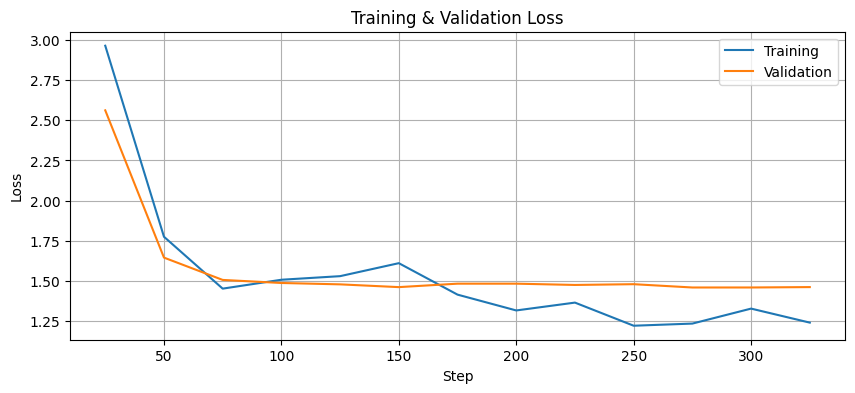

In [23]:
## plot the losses
plt.figure(figsize=(10, 4))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training')
plt.plot(eval_losses_df['step'], eval_losses_df['eval_loss'], label='Validation')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

In [24]:
## save final model as LoRA adapters
model.save_pretrained("gemma3-1b-sentiment-ft-adapter")  # Local saving
tokenizer.save_pretrained("gemma3-1b-sentiment-ft-adapter")

('gemma3-1b-sentiment-ft-adapter/tokenizer_config.json',
 'gemma3-1b-sentiment-ft-adapter/special_tokens_map.json',
 'gemma3-1b-sentiment-ft-adapter/chat_template.jinja',
 'gemma3-1b-sentiment-ft-adapter/tokenizer.model',
 'gemma3-1b-sentiment-ft-adapter/added_tokens.json',
 'gemma3-1b-sentiment-ft-adapter/tokenizer.json')

In [25]:
## SAVE FINETUNED MODEL LOCALLY (After merging PEFT weights) ##
model.save_pretrained_merged("gemma3-1b-sentiment-ft", tokenizer,token=hf_token)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [03:02<00:00, 182.27s/it]


In [26]:
## save the finetuned model for local inference on CPU, as GGUF file
model.save_pretrained_gguf("gemma3-1b-sentiment-ft",
                           quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported currently
   )

Unsloth: Updating system package directories
Unsloth: Install GGUF and other packages
Unsloth GGUF:hf-to-gguf:Loading model: gemma3-1b-sentiment-ft
Unsloth GGUF:hf-to-gguf:Model architecture: Gemma3ForCausalLM
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model.safetensors'
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {1152, 262144}
Unsloth GGUF:hf-to-gguf:output_norm.weight,                torch.bfloat16 --> F32, shape = {1152}
Unsloth GGUF:hf-to-gguf:Set meta model
Unsloth GGUF:hf-to-gguf:Set model parameters
Unsloth GGUF:hf-to-gguf:Set model quantization version
Unsloth GGUF:hf-to-gguf:Set model tokenizer
Unsloth GGUF:gguf.vocab:Setting special token type bos to 2
Unsloth GGUF:gguf.vocab:Setting special token type eos to 106
Unsloth GGUF:gguf.vocab:Setting special token type unk to 3
Unsloth GGUF:gguf.vocab:Setting

Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to gemma3-1b-sentiment-ft.Q8_0.gguf with size = 1.1G
Unsloth: Successfully saved GGUF to:
gemma3-1b-sentiment-ft.Q8_0.gguf


['gemma3-1b-sentiment-ft.Q8_0.gguf']